## Remember to open terminal and run: conda activate ilab-tensorflow to import shap

In [1]:
import shap

In [2]:
import sys
sys.path.append('/explore/nobackup/people/gtamkin/dev/AGB/mpf-model-factories/MultiPathFusion')

In [3]:
from multi_path_fusion.src.training.train_gt import train

from multi_path_fusion.src.utils.mlflow_helpers import setup_mlflow, log_params
from multi_path_fusion.src.utils.data_generator_helpers import load_data_generator
from multi_path_fusion.src.utils.model_helpers import get_model_factory

2023-12-27 14:10:11.497809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-27 14:10:11.605335: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
from tensorflow import keras
import json
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import rasterio
import time

import pickle
import tensorflow as tf

In [11]:
num_bands = 21
cfg_path = '/panfs/ccds02/home/gtamkin/dev/AGB/monte-carlo/monte-carlo/tests/exp_7bands.json'
modelPath = '/explore/nobackup/projects/ilab/data/AGB/test/mlruns/exp_7bands/12262023/MODELS/Exp_7bands_pickle::502671461260014182.keras'
archive_test_generator_id = '/explore/nobackup/projects/ilab/data/AGB/test/mlruns/exp_7bands/12262023/TRIALS/Exp_7bands_pickle::502671461260014182.keras.test_generator.data'
if num_bands > 7:
    cfp_path = '/panfs/ccds02/home/gtamkin/dev/AGB/monte-carlo/monte-carlo/tests/exp_all21bands.json'
    modelPath = '/explore/nobackup/projects/ilab/data/AGB/test/mlruns/exp_all12bands/12272023/MODELS/Exp_all21bands_pickle::839220614809774088.keras'
    archive_test_generator_id = '/explore/nobackup/projects/ilab/data/AGB/test/mlruns/exp_all12bands/12272023/TRIALS/Exp_all21bands_pickle::839220614809774088.keras.test_generator.data'

print(cfp_path, modelPath, archive_test_generator_id)
with open(cfp_path, 'r') as f:
    config = json.load(f)
    models_config = config["models"]
    data_generator_config = config["data_generator"]
    mlflow_config = config["mlflow"]
    
print(mlflow_config)


/panfs/ccds02/home/gtamkin/dev/AGB/monte-carlo/monte-carlo/tests/exp_all21bands.json /explore/nobackup/projects/ilab/data/AGB/test/mlruns/exp_all12bands/12272023/MODELS/Exp_all21bands_pickle::839220614809774088.keras /explore/nobackup/projects/ilab/data/AGB/test/mlruns/exp_all12bands/12272023/TRIALS/Exp_all21bands_pickle::839220614809774088.keras.test_generator.data
{'TRACKING_URI': '/explore/nobackup/projects/ilab/data/AGB/test/mlruns/exp_all21bands', 'EXPERIMENT_NAME': 'Exp_all21bands_pickle'}


In [7]:
model_config = models_config[0]

mlflow_config = setup_mlflow(mlflow_config)

In [8]:
keywordAll = ['ARI', 'CAI', 'CRI550', 'CRI700', 'EVI', 'EVI2', 'fPAR', 'LAI', 'MCTI', 'MSI',
        'NDII', 'NDLI', 'NDNI', 'NDVI', 'NDWI', 'NIRv', 'PRIn', 'PRIw', 'SAVI', 'WBI', 'Albedo']

print('keywordAll:', keywordAll)

keyword7 = list()
keyword7.append('PRIw')
keyword7.append('NDVI')
keyword7.append('MCTI')
keyword7.append('CRI550')
keyword7.append('WBI')
keyword7.append('LAI')
keyword7.append('MSI')

keyword = keywordAll
#print('keyword7:', keyword7)


keywordAll: ['ARI', 'CAI', 'CRI550', 'CRI700', 'EVI', 'EVI2', 'fPAR', 'LAI', 'MCTI', 'MSI', 'NDII', 'NDLI', 'NDNI', 'NDVI', 'NDWI', 'NIRv', 'PRIn', 'PRIw', 'SAVI', 'WBI', 'Albedo']


In [9]:
# load model instead of creating it
reload_model = True


In [13]:
if (reload_model == True):
    test_generator = pickle.load(open(archive_test_generator_id, "rb"))
else:
    train_generator = load_data_generator(data_generator_config, 'train')
    validate_generator = load_data_generator(data_generator_config, 'validate')
    test_generator = load_data_generator(data_generator_config, 'test')


In [16]:
print(test_generator.file_x_stack[20])

[0.10113806 0.08550429 0.07851141 ... 0.10232218 0.11396239 0.11575518]


In [17]:
    # load model instead of creating it
    reload_model = True
    model_type = model_config.get("model_type", "Sequential")  
    model_factory = get_model_factory(model_type)  
    if (reload_model == True):
#        modelPath = '/explore/nobackup/projects/ilab/data/AGB/test/mlruns/exp_7bands/12262023/MODELS/Exp_7bands_pickle::502671461260014182.keras'
        #modelPath = '/explore/nobackup/projects/ilab/data/AGB/test/mlruns/12172023-all21bands/MODELS/MpfSimulation_override_config-all21bands::473312591561682810.keras.1217202_0728'
        print('reloading model:', modelPath)
        model = tf.keras.models.load_model(modelPath)    
    else:
        print('creating model:', modelPath)
        # model_type = model_config.get("model_type", "Sequential")  
        # model_factory = get_model_factory(model_type)  
        model = model_factory.create_model(model_config, data_generator_config)
        model = model_factory.compile_model(model, model_config)

        # TODO: potentially add an option for being able to load in a previous model 
        # (such as using an encoder previously and training on the latent space instead of the original data)

        # train_generator = load_data_generator(data_generator_config, 'train')
        # validate_generator = load_data_generator(data_generator_config, 'validate')
        # test_generator = load_data_generator(data_generator_config, 'test')

        # probably not needed - will delete soon
        # run_name = get_unique_run_name(mlflow_config, model_config.get('model_name', None))
        with mlflow.start_run(experiment_id=mlflow_config['EXPERIMENT_ID'], run_name=model_config.get("model_name", None), description=model_config.get("model_description", ""), nested=False) as run:
            model_factory.autolog()
            log_params(model_config)
            RUN_ID = mlflow.active_run().info.run_id
            print(f"STARTING RUN: {RUN_ID}")

            # TODO: figure out best spot to put this function in, or if there needs to be multiple
            # "extras" depending on where in the training flow you want it to occur
            # put any miscellaneous project-specific code here
            model_factory.extras(model, train_generator, validate_generator, test_generator)

            t0 = time.time()

            # TODO: figure out a way to make this if statement more generic 
            # problem is keras model summary best done before training, xgboost summary only able to be done after
            if model_type == "Sequential" or "Keras":
                model_factory.summary(model)
            history = model_factory.train_model(model, train_generator, validate_generator, model_config)
    #        history2 = model_factory.train_model(model, train_generator, validate_generator, model_config)
            print(f'history: {history.history}')
    #        print(f'history2: {history2.history}')

            t1 = time.time()
            total_time = t1 - t0

            mlflow.log_param("Training time", total_time)

            print()
            print("Total time for model.fit() processing is: " + str(total_time) + " seconds.")

#model_factory.plot_metrics(model, test_generator, history)

# debugging
print("Finished successfully")

reloading model: /explore/nobackup/projects/ilab/data/AGB/test/mlruns/exp_all12bands/12272023/MODELS/Exp_all21bands_pickle::839220614809774088.keras
Finished successfully


2023-12-27 14:12:51.178352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
if model_type == "XGBoost":
    model_factory.summary(model)

predictions = model_factory.predict(model, test_generator)
test_results = model_factory.evaluate(model, test_generator)

# debugging
print(f'predictions: {predictions}')
print(f'test results: {test_results}')

#model_factory.log_metrics(test_results)
#            model_factory.plot_metrics(model, test_generator, history)




2000/2000 [==============================] - 2s 695us/step - loss: 1.5726 - accuracy: 0.0430
predictions: [[0.19255114 0.20135504 0.22137786 0.2535448  0.13117118]
 [0.19815606 0.20500973 0.21719955 0.24572586 0.13390881]
 [0.1952717  0.19998218 0.21530418 0.25089175 0.13855013]
 ...
 [0.19635533 0.20464748 0.21817686 0.24976175 0.13105856]
 [0.19528726 0.20590968 0.22203898 0.25022668 0.12653743]
 [0.19783014 0.21091557 0.22303581 0.24496755 0.12325092]]
test results: {'test loss': 1.572607398033142, 'test accuracy': 0.04301999881863594}


In [19]:
# Transpose test data for shap_values generation
import pandas as pd
df = pd.DataFrame(data=test_generator.file_x_stack)
X = df.transpose()
X.iloc[:, :]
print(X.shape, X.shape[0], X.shape[1])

(100000, 21) 100000 21


In [20]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.KernelExplainer(model.predict, X.iloc[:50, :])

2/2 [==============================] - 0s 2ms/step


In [23]:
shap_values0to50 = explainer.shap_values(X.iloc[0:50, :], nsamples=500)

  0%|          | 0/50 [00:00<?, ?it/s]

782/782 [==============================] - 0s 556us/step


In [24]:
print(len(shap_values0to50), '\n', shap_values0to50[0].shape)

5 
 (50, 21)


bin value 0: [ < -1.0] = summary_plot(shap_values0to50[0]


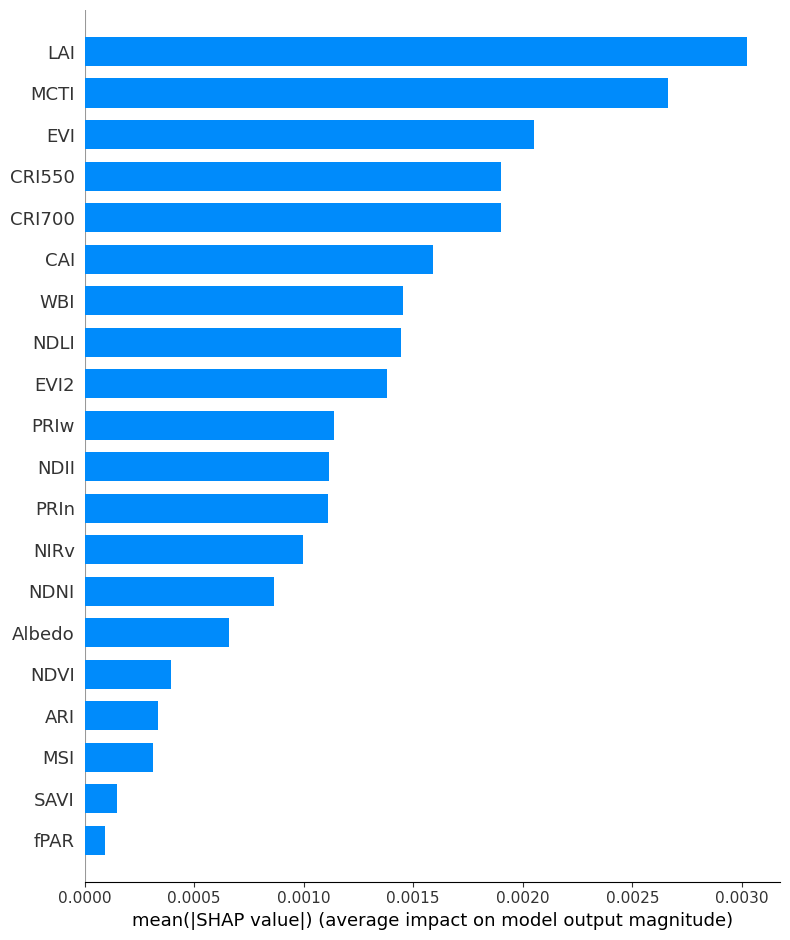

In [25]:
# print according to most in particular bin:  0 < -1.0, 1 < -0.5, 2 < 0, 3 < 0.5, 4 < 1.0
print('bin value 0: [ < -1.0] = summary_plot(shap_values0to50[0]') 
shap.summary_plot(shap_values0to50[0], X.iloc[0:50, :], plot_type="bar", feature_names=keyword)

bin value 3: [0.5, 1.0] = summary_plot(shap_values0to50[3]


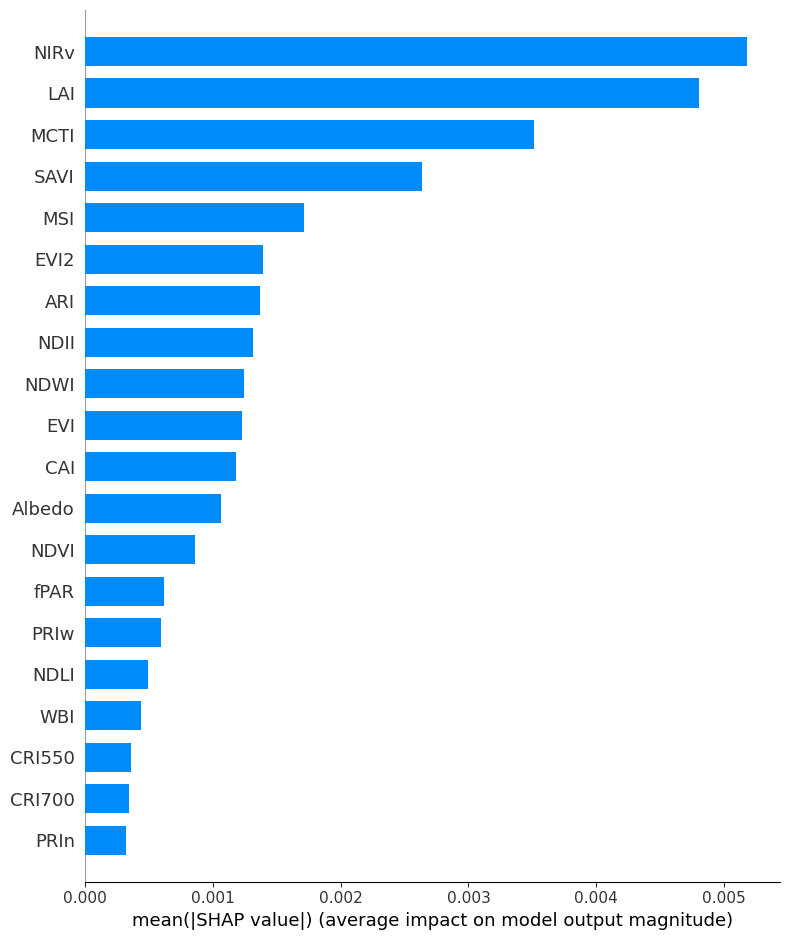

In [26]:
# print according to most in particular bin:  0 < -1.0, 1 < -0.5, 2 < 0, 3 < 0.5, 4 < 1.0
print('bin value 3: [0.5, 1.0] = summary_plot(shap_values0to50[3]') 
shap.summary_plot(shap_values0to50[3], X.iloc[0:50, :], plot_type="bar", feature_names=keyword)

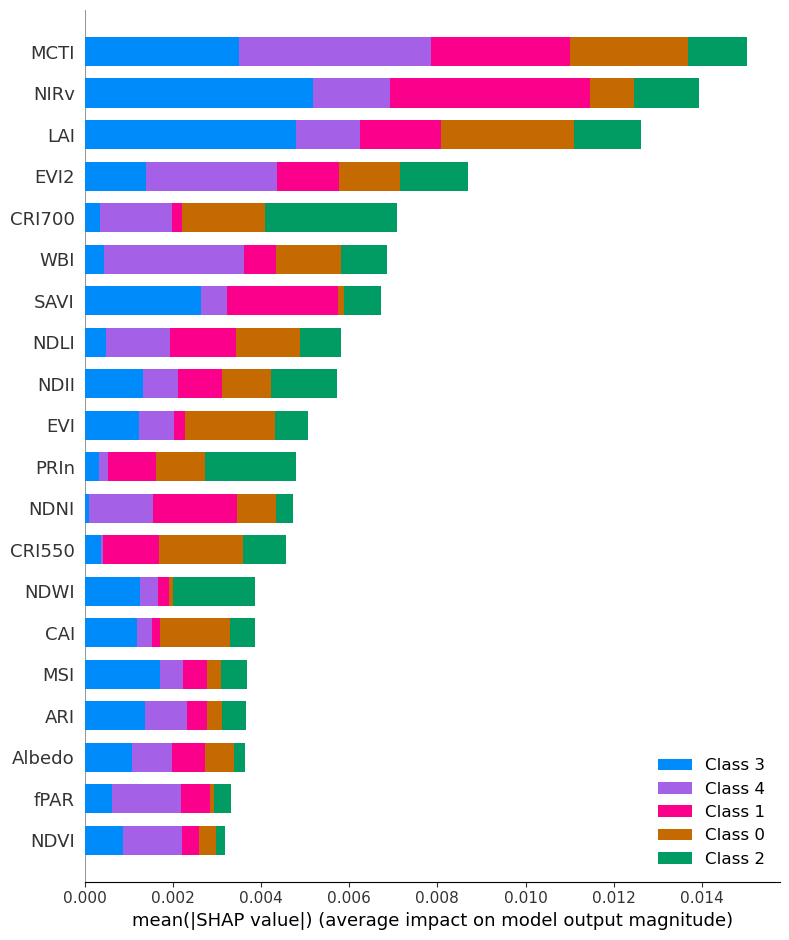

In [27]:
shap.summary_plot(shap_values0to50, X, plot_type="bar", feature_names=keyword)

In [28]:
# get shap values for a single instance (299) of test data
shap_values299 = explainer.shap_values(X.iloc[299, :], nsamples=500)

197/197 [==============================] - 0s 532us/step


In [30]:
# get shap values for a slice of 50 rows (instances) of test data
shap_values50 = explainer.shap_values(X.iloc[280:330, :], nsamples=500)

  0%|          | 0/50 [00:00<?, ?it/s]

197/197 [==============================] - 0s 673us/step


In [31]:
shap_values11 = explainer.shap_values(X.iloc[88888:88899, :], nsamples=500)

  0%|          | 0/11 [00:00<?, ?it/s]

197/197 [==============================] - 0s 665us/step


In [32]:
# compare shap_values for slice of 50 11, and 1 row
print ('\nshap_values [299]: ',  len(shap_values299), shap_values299[0].shape, '\n', shap_values299[0][0], '\n', shap_values299[len(shap_values299)-1][0])
print ('\nshap_values11 [88888:88899]: ', len(shap_values11), shap_values11[0].shape,  '\n', shap_values11[0][0], '\n', shap_values11[len(shap_values11)-1][0])
print ('\nshap_values50 [0:49]: ', len(shap_values50), shap_values50[0].shape,  '\n', shap_values50[0][0], '\n', shap_values50[len(shap_values50)-1][0])


shap_values [299]:  5 (7,) 
 0.0039409957003025894 
 -0.0029030142412298917

shap_values11 [88888:88899]:  5 (11, 7) 
 [ 0.00398688 -0.00031413  0.0010344  -0.00207589 -0.01085438 -0.00417029
  0.0008    ] 
 [-0.00289116 -0.00011675 -0.00217842  0.00140981  0.00459093  0.00323664
 -0.00065691]

shap_values50 [0:49]:  5 (50, 7) 
 [ 0.0038344  -0.00310878  0.00114895 -0.00238179 -0.00138866  0.00468632
 -0.00022683] 
 [-0.00275357  0.00176864 -0.00219899  0.00146582  0.00043567 -0.00276312
  0.00052194]


In [ ]:
# display summary of 11 instances - see that MSI & LAI have the highest average impact using 1st row of slice of 11
print(shap_values11[0].shape)
shap.summary_plot(shap_values11[0], X.iloc[88888:88899, :], plot_type="bar", feature_names=keyword)

In [ ]:
# display summary of 11 instances - see that MSI & WBI have the highest average impact using last row of slice of 11
print(shap_values11[4].shape)
shap.summary_plot(shap_values11[4], X.iloc[88888:88899, :], plot_type="bar", feature_names=keyword)

In [ ]:
# display summary of 11 instances - see that MSI & WBI have the highest average impact using last row of slice of 11
print(len(shap_values11), shap_values11[0].shape)
shap.summary_plot(shap_values11, X.iloc[88888:88899, :], plot_type="bar", feature_names=keyword)

5 (50, 7)


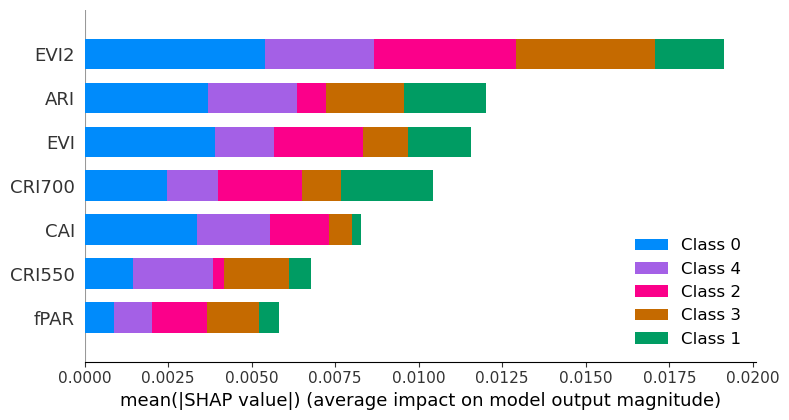

In [33]:
# display summary of 50 instances - see that MSI & LAI have the highest average impact using 1st row of slice of 50
print(len(shap_values50), shap_values50[0].shape)
shap.summary_plot(shap_values50, X.iloc[280:330, :], plot_type="bar", feature_names=keyword)

In [ ]:
# display summary of 50 instances - see that MSI & CRI550 have the highest average impact using last row of slice of 50
shap.summary_plot(shap_values50[4], X.iloc[280:330, :], plot_type="bar", feature_names=keyword)

In [36]:
# from _beeswarm.py.   
#        feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))


def permutation_importance(shap_values):
#    print("\nshap_values:\n", shap_values.shape)
#    print("\nshap_values:\n", shap_values, shap_values.dtype, shap_values.shape)

    shap_values_sum_axis1 = np.sum(shap_values, axis=1)
#    print("\nshap_values_sum_axis1: np.sum(shap_values_sum, axis=1) [sum across row]\n", shap_values_sum_axis1)

    shap_values_sum_axis0 = np.sum(shap_values, axis=0)
#    print("\nshap_values_sum_axis0 : np.sum(shap_values, axis=0) [sum down column]\n", shap_values_sum_axis0)

    shap_values_sum_argsort = np.argsort(shap_values_sum_axis0)
#    print ("\nshap_values_sum_argsort: np.argsort(shap_values_sum_axis0)  [sum down column]\n", shap_values_sum_argsort)

    shap_values_abs = np.abs(shap_values)
#    print("\nshap_values_abs: (np.abs(nd_a))\n", shap_values_abs)

    shap_values_abs_sum_axis1 = np.sum(shap_values_abs, axis=1)
#    print("\nshap_values_abs_sum_axis1: np.sum(shap_values_abs, axis=1) [sum across row]\n", shap_values_abs_sum_axis1)

    shap_values_abs_sum_axis0 = np.sum(shap_values_abs, axis=0)
#    print("\nshap_values_abs_sum_axis0: np.sum(shap_values_abs, axis=0) [sum down column]\n", shap_values_abs_sum_axis0)

    shap_values_abs_sum_argsort = np.argsort(shap_values_abs_sum_axis0)
#    print("\n**** feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))")
#    print ("shap_values_abs_sum_argsort: np.argsort(shap_values_abs_sum_axis0)  [sum down column]\n *", shap_values_abs_sum_argsort)

    feature_order = shap_values_abs_sum_argsort
#    if not (shap_values_abs_sum_argsort[0] == feature_order[0]): raise AssertionError
#    print('\nfeature_order:\n', feature_order)
    
    return shap_values_sum_axis1, shap_values_sum_axis0, shap_values_sum_argsort, \
        shap_values_abs, shap_values_abs_sum_axis1, shap_values_abs_sum_axis0, shap_values_abs_sum_argsort, feature_order

In [37]:
# example row/column statistics with test matrix that is easy to predict.  Note that argsort goes from low to high.
a = [[1, 2, 3, 4, 5, 6, -7], [1, 2, 3, 4, 5, -29, 7], [1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7], [-1, 2, 3, 4, 5, 6, 7]]
print(np.array(a))
permutation_importance(np.array(a))

[[  1   2   3   4   5   6  -7]
 [  1   2   3   4   5 -29   7]
 [  1   2   3   4   5   6   7]
 [  1   2   3   4   5   6   7]
 [  1   2   3   4   5   6   7]
 [ -1   2   3   4   5   6   7]]


(array([14, -7, 28, 28, 28, 26]),
 array([ 4, 12, 18, 24, 30,  1, 28]),
 array([5, 0, 1, 2, 3, 6, 4]),
 array([[ 1,  2,  3,  4,  5,  6,  7],
        [ 1,  2,  3,  4,  5, 29,  7],
        [ 1,  2,  3,  4,  5,  6,  7],
        [ 1,  2,  3,  4,  5,  6,  7],
        [ 1,  2,  3,  4,  5,  6,  7],
        [ 1,  2,  3,  4,  5,  6,  7]]),
 array([28, 51, 28, 28, 28, 28]),
 array([ 6, 12, 18, 24, 30, 59, 42]),
 array([0, 1, 2, 3, 4, 6, 5]),
 array([0, 1, 2, 3, 4, 6, 5]))

In [38]:
# example row/column statistics with test matrix that is easy to predict.  Note that argsort goes from low to high.
print(np.array(shap_values11))
permutation_importance(np.array(shap_values11))

[[[ 3.98688111e-03 -3.14129531e-04  1.03439694e-03 -2.07589486e-03
   -1.08543826e-02 -4.17029027e-03  7.99996642e-04]
  [ 3.67874756e-03  1.91798955e-03  1.31562632e-03 -2.62429410e-03
    3.46626409e-03  3.26843934e-03 -6.35209351e-04]
  [ 3.52239310e-03  4.69229876e-03  1.48702107e-03 -2.95767563e-03
    5.96948115e-03 -8.78171602e-03 -1.49247370e-03]
  [ 3.84172564e-03 -7.04292753e-03  9.84356923e-04 -1.58358731e-03
   -6.18348758e-03  6.42817601e-03  6.60471773e-04]
  [ 3.33578939e-03  4.37601882e-03 -1.96222986e-03 -2.37869018e-03
    6.24222822e-03  9.82356981e-03 -9.98546946e-04]
  [ 3.95827992e-03  1.81618934e-03  1.36506730e-03 -2.54823182e-03
    2.32441783e-03 -8.82140223e-03 -2.36606944e-04]
  [ 3.21694588e-03  2.89488526e-03 -1.18827169e-02 -2.09236214e-03
    4.32480368e-03  1.05586215e-02 -8.47615966e-04]
  [ 3.73280360e-03 -8.21571240e-04  1.19235835e-03 -2.48208209e-03
    6.95986234e-04  6.04234878e-03 -6.07077770e-05]
  [ 3.80089289e-03  8.41455194e-04  1.27385580e-

(array([[ 0.04011885,  0.01045813, -0.00265664, -0.0261054 ,  0.01437622,
          0.03500177, -0.00479087],
        [-0.02745907,  0.00232162,  0.00069566, -0.03045886,  0.00885718,
         -0.01214801, -0.00731522],
        [-0.00939549, -0.00687382,  0.00236405,  0.02765231, -0.01069475,
         -0.03015027,  0.0126741 ],
        [ 0.02534457,  0.00359211,  0.00171745,  0.01287729, -0.00523268,
          0.03166894, -0.00915213],
        [-0.02860885, -0.00949802, -0.00212049,  0.01603469, -0.00730598,
         -0.02437242,  0.00858415]]),
 array([[ 1.04396826e-08,  1.82950781e-08,  3.83846820e-09,
          2.13572668e-08,  1.90028832e-08,  1.59729805e-08,
          1.51037461e-08],
        [ 3.19594429e-09,  8.27475674e-09,  5.89305445e-09,
         -2.71059216e-10,  5.59503126e-09,  3.92361771e-09,
          2.89295416e-09],
        [ 7.27673425e-10,  1.40070918e-09, -2.54809856e-09,
         -1.64906181e-09, -6.85701764e-09, -5.06887830e-09,
         -1.20451049e-09],
       

In [39]:
permutation_importance(np.array(shap_values11[0]))

(array([-0.01159342,  0.01038756,  0.00243933, -0.00289527,  0.01843814,
        -0.00214229,  0.00617256,  0.00829914,  0.01019962,  0.01055687,
         0.01653984]),
 array([ 0.04011885,  0.01045813, -0.00265664, -0.0261054 ,  0.01437622,
         0.03500177, -0.00479087]),
 array([3, 6, 2, 1, 4, 5, 0]),
 array([[3.98688111e-03, 3.14129531e-04, 1.03439694e-03, 2.07589486e-03,
         1.08543826e-02, 4.17029027e-03, 7.99996642e-04],
        [3.67874756e-03, 1.91798955e-03, 1.31562632e-03, 2.62429410e-03,
         3.46626409e-03, 3.26843934e-03, 6.35209351e-04],
        [3.52239310e-03, 4.69229876e-03, 1.48702107e-03, 2.95767563e-03,
         5.96948115e-03, 8.78171602e-03, 1.49247370e-03],
        [3.84172564e-03, 7.04292753e-03, 9.84356923e-04, 1.58358731e-03,
         6.18348758e-03, 6.42817601e-03, 6.60471773e-04],
        [3.33578939e-03, 4.37601882e-03, 1.96222986e-03, 2.37869018e-03,
         6.24222822e-03, 9.82356981e-03, 9.98546946e-04],
        [3.95827992e-03, 1.81618934e

In [40]:
permutation_importance(np.array(shap_values11[1]))

(array([-0.00941448, -0.00610079,  0.00043795, -0.01095205, -0.00480629,
        -0.00197877, -0.0019689 , -0.0085009 , -0.0071371 , -0.00841728,
        -0.00666807]),
 array([-0.02745907,  0.00232162,  0.00069566, -0.03045886,  0.00885718,
        -0.01214801, -0.00731522]),
 array([3, 0, 5, 6, 2, 1, 4]),
 array([[0.00251264, 0.00026562, 0.00064314, 0.00237407, 0.00446017,
         0.00127366, 0.00096374],
        [0.00253784, 0.0002156 , 0.00055437, 0.00292051, 0.00165323,
         0.00130725, 0.00064964],
        [0.00223399, 0.0001691 , 0.00068314, 0.00278901, 0.00296306,
         0.00357135, 0.00022123],
        [0.00257628, 0.00028475, 0.00059129, 0.00221761, 0.00273838,
         0.00220887, 0.00090438],
        [0.00249896, 0.00040005, 0.00073151, 0.00303108, 0.00334978,
         0.00337995, 0.00037764],
        [0.00249274, 0.00010092, 0.00069625, 0.00257041, 0.00106726,
         0.00347045, 0.00085799],
        [0.002311  , 0.00023067, 0.00524366, 0.00287613, 0.00257332,
    

In [41]:
# example row/column statistics with test matrix that is easy to predict.  Note that argsort goes from low to high.
#print(np.array(shap_values50))
_shap_values50_sum_axis1, _shap_values50_sum_axis0, _shap_value50s_sum_argsort, \
        _shap_values50_abs, _shap_values50_abs_sum_axis1, _shap_values50_abs_sum_axis0, _shap_values50_abs_sum_argsort, _feature50_order = \
        permutation_importance(np.array(shap_values50[0]))

print ('shap_values50[0] feature_order:\n', _feature50_order.shape, '\n', _feature50_order)

_shap_values50_sum_axis1, _shap_values50_sum_axis0, _shap_value50s_sum_argsort, \
        _shap_values50_abs, _shap_values50_abs_sum_axis1, _shap_values50_abs_sum_axis0, _shap_values50_abs_sum_argsort, _feature50_order = \
        permutation_importance(np.array(shap_values50))

print ('\nshap_values5[0]0 feature_order:\n', _feature50_order[0].shape, '\n', _feature50_order[0], '\n',  _shap_values50_abs_sum_axis0[0])
print ('\nshap_values50 feature_order:\n', _feature50_order.shape, '\n', _feature50_order, '\n',  _shap_values50_abs_sum_axis0)

shap_values50[0] feature_order:
 (7,) 
 [6 2 3 1 0 4 5]

shap_values5[0]0 feature_order:
 (7,) 
 [6 4 2 1 3 0 5] 
 [0.01253209 0.00726853 0.00614183 0.01032489 0.00407758 0.01615553
 0.00276333]

shap_values50 feature_order:
 (50, 7) 
 [[6 4 2 1 3 0 5]
 [2 6 3 0 1 5 4]
 [2 6 3 0 1 5 4]
 [4 6 1 2 3 0 5]
 [4 1 6 2 5 3 0]
 [6 2 5 3 4 1 0]
 [6 2 1 3 0 4 5]
 [1 4 6 2 3 0 5]
 [1 6 2 5 4 3 0]
 [4 1 6 2 3 0 5]
 [1 2 6 5 0 3 4]
 [4 6 1 2 3 0 5]
 [6 2 4 3 1 0 5]
 [2 3 6 0 1 5 4]
 [6 4 2 1 3 0 5]
 [6 5 2 3 4 1 0]
 [2 6 1 3 5 0 4]
 [5 2 6 3 0 1 4]
 [1 6 4 3 0 2 5]
 [6 2 3 5 0 1 4]
 [1 4 6 2 5 3 0]
 [5 1 6 2 4 3 0]
 [2 6 1 3 0 4 5]
 [2 5 6 3 0 1 4]
 [6 5 1 4 2 3 0]
 [1 2 6 4 3 0 5]
 [2 6 0 3 1 5 4]
 [1 4 6 2 3 0 5]
 [2 6 1 3 0 5 4]
 [6 4 2 1 3 0 5]
 [2 6 0 3 1 4 5]
 [2 1 6 3 4 0 5]
 [6 4 1 2 5 3 0]
 [2 6 0 3 1 4 5]
 [2 6 1 3 0 5 4]
 [6 4 2 1 5 3 0]
 [2 6 3 0 1 4 5]
 [6 1 3 0 2 4 5]
 [6 2 1 0 3 4 5]
 [5 2 6 1 3 0 4]
 [2 3 1 0 4 5 6]
 [1 2 6 3 4 0 5]
 [4 6 1 2 3 0 5]
 [2 6 0 3 1 5 4]
 [1 6 2 4 3 0 5]

In [ ]:
bandLen = 21

bandOccurenceArr = np.zeros(bandLen)
print(bandOccurenceArr)
bandAbsSumArr = np.zeros(bandLen)
bandMaxArr = np.zeros(bandLen)
bandMinArr = np.zeros(bandLen)
bandMeanArr = np.zeros(bandLen)


In [47]:
import random
my_input = ['beleriand','mordor','hithlum','eol','morgoth','melian','thingol']
def random_generator(array,x,y):
    random.shuffle(array)
    result = []
    count = 0
    while count < x:
        section = []
        y1 = y * count
        y2 = y * (count + 1)
        for i in range (y1,y2):
            section.append(array[i])
        result.append(section)
        count += 1
    return result

In [48]:
print (random_generator(my_input,3,2))
print (random_generator(my_input,3,2))

[['mordor', 'eol'], ['beleriand', 'hithlum'], ['thingol', 'morgoth']]
[['eol', 'thingol'], ['beleriand', 'mordor'], ['morgoth', 'hithlum']]


In [50]:
bands = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
bands

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21']

In [56]:
import pandas as pd
df = pd.DataFrame(data=bands)
dft = df.transpose()
X = X_test = dft
X

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,17,9,14,4,18,10,6,3,15,11,...,12,2,8,13,5,21,20,1,7,16


In [63]:
print (random_generator(bands,2,10))
#print (random_generator(bands,3,2))

[['12', '20', '8', '1', '2', '17', '13', '14', '6', '9'], ['21', '16', '15', '18', '11', '4', '19', '5', '10', '3']]
